In [1]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
import tensorflow as tf
from tensorflow.python.framework import ops
from cnn_utils import *

%matplotlib inline
np.random.seed(1)

/home/tree/Downloads/yes/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/tree/Downloads/yes/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/home/tree/Downloads/yes/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/tree/Downloads/yes/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/tree/Downloads/yes/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size ch

In [2]:
# Loading the data (signs)
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

config = tf.ConfigProto()
config.gpu_options.allow_growth = True

y = 5


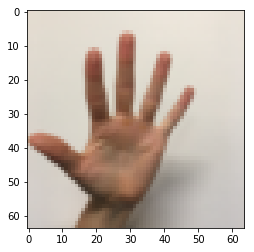

In [3]:
# Example of a picture
index = 3
plt.imshow(X_train_orig[index])
print ("y = " + str(np.squeeze(Y_train_orig[:, index])))

In [4]:
X_train = X_train_orig/255.
X_test = X_test_orig/255.
Y_train = convert_to_one_hot(Y_train_orig, 6).T
Y_test = convert_to_one_hot(Y_test_orig, 6).T
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))
conv_layers = {}

number of training examples = 1080
number of test examples = 120
X_train shape: (1080, 64, 64, 3)
Y_train shape: (1080, 6)
X_test shape: (120, 64, 64, 3)
Y_test shape: (120, 6)


#  Create placeholders

In [5]:
def create_placeholders(n_H0, n_W0, n_C0, n_y):
    X = tf.placeholder(tf.float32, shape= [None, n_H0, n_W0, n_C0])
    Y = tf.placeholder(tf.float32, shape= [None, n_y])
    
    return X, Y
    
    

In [6]:
X, Y = create_placeholders(64, 64, 3, 6)
print ("X = " + str(X))
print ("Y = " + str(Y))

X = Tensor("Placeholder:0", shape=(?, 64, 64, 3), dtype=float32)
Y = Tensor("Placeholder_1:0", shape=(?, 6), dtype=float32)


#  Initialize parameters

In [7]:
def initialize_parameters():
    tf.set_random_seed(1)
        
    W1 = tf.get_variable(name='W1', dtype=tf.float32, shape=(4, 4, 3, 8), initializer=tf.contrib.layers.xavier_initializer(seed = 0))
    W2 = tf.get_variable(name='W2', dtype=tf.float32, shape=(2, 2, 8, 16), initializer=tf.contrib.layers.xavier_initializer(seed = 0))
    
    parameters = {"W1": W1,
                  "W2": W2}
    
    return parameters



**tf.get_variable()**

 W = tf.get_variable(name, shape=None, dtype=tf.float32, initializer=None,
       regularizer=None, trainable=True, collections=None)

    1
    2

获取已存在的变量（要求不仅名字，而且初始化方法等各个参数都一样），如果不存在，就新建一个。
可以用各种初始化方法，不用明确指定值。

**tf.contrib.layers.xavier_initializer**

该函数返回一个用于初始化权重的初始化程序 “Xavier” 。

这个初始化器是用来保持每一层的梯度大小都差不多相同

In [8]:
tf.reset_default_graph()
with tf.Session() as sess_test:
    parameters = initialize_parameters()
    init = tf.global_variables_initializer()
    sess_test.run(init)
    print("W1 = " + str(parameters["W1"].eval()[1,1,1]))
    print("W2 = " + str(parameters["W2"].eval()[1,1,1]))

/home/tree/Downloads/yes/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/tree/Downloads/yes/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


W1 = [ 0.00131723  0.1417614  -0.04434952  0.09197326  0.14984085 -0.03514394
 -0.06847463  0.05245192]
W2 = [-0.08566415  0.17750949  0.11974221  0.16773748 -0.0830943  -0.08058
 -0.00577033 -0.14643836  0.24162132 -0.05857408 -0.19055021  0.1345228
 -0.22779644 -0.1601823  -0.16117483 -0.10286498]


# Forward propagation

In TensorFlow, there are built-in functions that carry out the convolution steps for you.



- **tf.nn.conv2d(X,W1, strides = [1,s,s,1], padding = 'SAME'):** given an input $X$ and a group of filters $W1$, this function convolves $W1$'s filters on X. The third input ([1,f,f,1]) represents the strides for each dimension of the input (m, n_H_prev, n_W_prev, n_C_prev). You can read the full documentation [here](https://www.tensorflow.org/api_docs/python/tf/nn/conv2d)

- **tf.nn.max_pool(A, ksize = [1,f,f,1], strides = [1,s,s,1], padding = 'SAME'):** given an input A, this function uses a window of size (f, f) and strides of size (s, s) to carry out max pooling over each window. You can read the full documentation [here](https://www.tensorflow.org/api_docs/python/tf/nn/max_pool)

- **tf.nn.relu(Z1):** computes the elementwise ReLU of Z1 (which can be any shape). You can read the full documentation [here.](https://www.tensorflow.org/api_docs/python/tf/nn/relu)

- **tf.contrib.layers.flatten(P)**: given an input P, this function flattens each example into a 1D vector it while maintaining the batch-size. It returns a flattened tensor with shape [batch_size, k]. You can read the full documentation [here.](https://www.tensorflow.org/api_docs/python/tf/contrib/layers/flatten)

- **tf.contrib.layers.fully_connected(F, num_outputs):** given a the flattened input F, it returns the output computed using a fully connected layer. You can read the full documentation [here.](https://www.tensorflow.org/api_docs/python/tf/contrib/layers/fully_connected)


In [9]:

def forward_propagation(X, parameters):
    """
    Implements the forward propagation for the model:
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED
    
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "W2"
                  the shapes are given in initialize_parameters

    Returns:
    Z3 -- the output of the last LINEAR unit
    """
    
    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    W2 = parameters['W2']
    
    ### START CODE HERE ###
    # CONV2D: stride of 1, padding 'SAME'
    Z1 = tf.nn.conv2d(X,W1, strides = [1,1,1,1], padding = 'SAME')
    # RELU
    A1 = tf.nn.relu(Z1)
    # MAXPOOL: window 8x8, sride 8, padding 'SAME'
    P1 = tf.nn.max_pool(A1, ksize = [1,8,8,1], strides = [1,8,8,1], padding = 'SAME')
    # CONV2D: filters W2, stride 1, padding 'SAME'
    Z2 = tf.nn.conv2d(P1,W2, strides = [1,1,1,1], padding = 'SAME')
    # RELU
    A2 = tf.nn.relu(Z2)
    # MAXPOOL: window 4x4, stride 4, padding 'SAME'
    P2 = tf.nn.max_pool(A2, ksize = [1,4,4,1], strides = [1,4,4,1], padding = 'SAME')
    # FLATTEN
    P2 = tf.contrib.layers.flatten(P2)
    # FULLY-CONNECTED without non-linear activation function (not not call softmax).
    # 6 neurons in output layer. Hint: one of the arguments should be "activation_fn=None" 
    Z3 = tf.contrib.layers.fully_connected(P2, 6, activation_fn=None)
    ### END CODE HERE ###

    return Z3

In [10]:
tf.reset_default_graph()

with tf.Session() as sess:
    np.random.seed(1)
    X, Y = create_placeholders(64, 64, 3, 6)
    parameters = initialize_parameters()
    Z3 = forward_propagation(X, parameters)
    init = tf.global_variables_initializer()
    sess.run(init)
    a = sess.run(Z3, {X: np.random.randn(2,64,64,3), Y: np.random.randn(2,6)})
    print("Z3 = " + str(a))

Z3 = [[ 1.4416982  -0.24909675  5.4504995  -0.26189643 -0.2066989   1.3654672 ]
 [ 1.4070848  -0.02573231  5.0892797  -0.48669893 -0.40940714  1.2624854 ]]


# compute cost

In [11]:
def compute_cost(Z3, Y):
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=Z3, labels=Y))
    
    return cost


In [12]:
tf.reset_default_graph()

with tf.Session(config = config) as sess:
    np.random.seed(1)
    X, Y = create_placeholders(64, 64, 3, 6)
    parameters = initialize_parameters()
    Z3 = forward_propagation(X, parameters)
    cost = compute_cost(Z3, Y)
    init = tf.global_variables_initializer()
    sess.run(init)
    a = sess.run(cost, {X: np.random.randn(4,64,64,3), Y: np.random.randn(4,6)})
    print("cost = " + str(a))

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.

cost = 4.6648703


In [24]:
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.009, num_epochs = 100,
          minibatch_size = 64, print_cost = True):
    tf.reset_default_graph() 
    #清除默认图的堆栈，并设置全局图为默认图
    tf.set_random_seed(1)
    seed = 3
    (m, n_H0, n_W0, n_C0) = X_train.shape
    n_y = Y_train.shape[1]
    costs = []
    
    X, Y = create_placeholders(n_H0, n_W0, n_C0, n_y)
    
    parameters = initialize_parameters()
    
    Z3 = forward_propagation(X, parameters)
    
    cost = compute_cost(Z3, Y)
    
    optimizer = tf.train.AdamOptimizer(learning_rate= learning_rate).minimize(cost)
    
    init = tf.global_variables_initializer()
    
    with tf.Session(config= config) as sess:
        sess.run(init)
        
        for epoch in range(num_epochs):
            minibatch_cost = 0
            num_minibatches = int(m / minibatch_size)
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)
            
            for minibatch in minibatches:
                (minibatch_X, minibatch_Y) = minibatch
                
                _, temp_cost = sess.run([optimizer, cost], feed_dict = {X:minibatch_X, Y:minibatch_Y})
                
                minibatch_cost += temp_cost / num_minibatches
        
            if print_cost == True and epoch % 5 ==0:
                print("cost after epoch %i: %f" %(epoch, minibatch_cost))
            if print_cost == True and epoch % 1 ==0:
                costs.append(minibatch_cost)
        
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("learning rate = " + str(learning_rate))
        plt.show()
        
        predict_op = tf.argmax(Z3, 1)
        correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))
        #tf.equal比较相等元素返回矩阵(true和false)
        
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        #tf.cast转换类型函数
        print(accuracy)
        train_accuracy = accuracy.eval({X:X_train, Y:Y_train})
        test_accruacy = accuracy.eval({X:X_test, Y:Y_test})
        print("train accuracy:", train_accuracy)
        print("test accuracy:", test_accruacy)
        
        return train_accuracy, test_accruacy
        
        
        
        
    
    

关于tf.argmax，我看到网上的资料有些杂乱难以理解，所以写这篇文章。在tf.argmax( , )中有两个参数，第一个参数是矩阵，第二个参数是0或者1。0表示的是按列比较(将同一列哪一行数字最大输出)返回最大值的索引，1表示按行比较返回最大值的索引

cost after epoch 0: 1.921332
cost after epoch 5: 1.904156
cost after epoch 10: 1.904309
cost after epoch 15: 1.904477
cost after epoch 20: 1.901876
cost after epoch 25: 1.784077
cost after epoch 30: 1.681053
cost after epoch 35: 1.618208
cost after epoch 40: 1.597973
cost after epoch 45: 1.567265
cost after epoch 50: 1.553831
cost after epoch 55: 1.499270
cost after epoch 60: 1.443608
cost after epoch 65: 1.273833
cost after epoch 70: 1.183423
cost after epoch 75: 1.130524
cost after epoch 80: 1.095996
cost after epoch 85: 1.069124
cost after epoch 90: 1.036066
cost after epoch 95: 1.006603


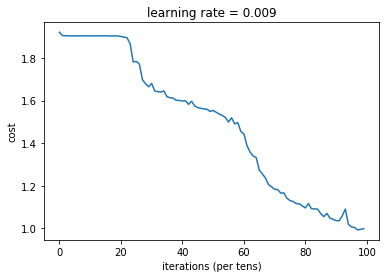

Tensor("Mean_1:0", shape=(), dtype=float32)
train accuracy: 0.66481483
test accuracy: 0.59166664


ValueError: not enough values to unpack (expected 3, got 2)

In [25]:
_, _, parameters = model(X_train, Y_train, X_test, Y_test)

In [22]:
# GRADED FUNCTION: model

def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.009,
          num_epochs = 100, minibatch_size = 64, print_cost = True):
    """
    Implements a three-layer ConvNet in Tensorflow:
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED
    
    Arguments:
    X_train -- training set, of shape (None, 64, 64, 3)
    Y_train -- test set, of shape (None, n_y = 6)
    X_test -- training set, of shape (None, 64, 64, 3)
    Y_test -- test set, of shape (None, n_y = 6)
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every 100 epochs
    
    Returns:
    train_accuracy -- real number, accuracy on the train set (X_train)
    test_accuracy -- real number, testing accuracy on the test set (X_test)
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(1)                             # to keep results consistent (tensorflow seed)
    seed = 3                                          # to keep results consistent (numpy seed)
    (m, n_H0, n_W0, n_C0) = X_train.shape             
    n_y = Y_train.shape[1]                            
    costs = []                                        # To keep track of the cost
    
    # Create Placeholders of the correct shape
    ### START CODE HERE ### (1 line)
    X, Y = create_placeholders(n_H0, n_W0, n_C0, n_y)
    ### END CODE HERE ###

    # Initialize parameters
    ### START CODE HERE ### (1 line)
    parameters = initialize_parameters()
    ### END CODE HERE ###
    
    # Forward propagation: Build the forward propagation in the tensorflow graph
    ### START CODE HERE ### (1 line)
    Z3 = forward_propagation(X, parameters)
    ### END CODE HERE ###
    
    # Cost function: Add cost function to tensorflow graph
    ### START CODE HERE ### (1 line)
    cost = compute_cost(Z3, Y)
    ### END CODE HERE ###
    
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer that minimizes the cost.
    ### START CODE HERE ### (1 line)
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    ### END CODE HERE ###
    
    # Initialize all the variables globally
    init = tf.global_variables_initializer()
     
    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        
        # Do the training loop
        for epoch in range(num_epochs):

            minibatch_cost = 0.
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:

                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                # IMPORTANT: The line that runs the graph on a minibatch.
                # Run the session to execute the optimizer and the cost, the feedict should contain a minibatch for (X,Y).
                ### START CODE HERE ### (1 line)
                _ , temp_cost = sess.run([optimizer, cost], feed_dict={X:minibatch_X, Y:minibatch_Y})
                ### END CODE HERE ###
                
                minibatch_cost += temp_cost / num_minibatches
                

            # Print the cost every epoch
            if print_cost == True and epoch % 5 == 0:
                print ("Cost after epoch %i: %f" % (epoch, minibatch_cost))
            if print_cost == True and epoch % 1 == 0:
                costs.append(minibatch_cost)
        
        
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # Calculate the correct predictions
        predict_op = tf.argmax(Z3, 1)
        correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))
        
        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        print(accuracy)
        train_accuracy = accuracy.eval({X: X_train, Y: Y_train})
        test_accuracy = accuracy.eval({X: X_test, Y: Y_test})
        print("Train Accuracy:", train_accuracy)
        print("Test Accuracy:", test_accuracy)
                
        return train_accuracy, test_accuracy, parameters

Cost after epoch 0: 1.921332
Cost after epoch 5: 1.904156
Cost after epoch 10: 1.904309
Cost after epoch 15: 1.904477
Cost after epoch 20: 1.901876
Cost after epoch 25: 1.784078
Cost after epoch 30: 1.681052
Cost after epoch 35: 1.618207
Cost after epoch 40: 1.597972
Cost after epoch 45: 1.566707
Cost after epoch 50: 1.554486
Cost after epoch 55: 1.502187
Cost after epoch 60: 1.461035
Cost after epoch 65: 1.304477
Cost after epoch 70: 1.201501
Cost after epoch 75: 1.144201
Cost after epoch 80: 1.101159
Cost after epoch 85: 1.092304
Cost after epoch 90: 1.054145
Cost after epoch 95: 1.014669


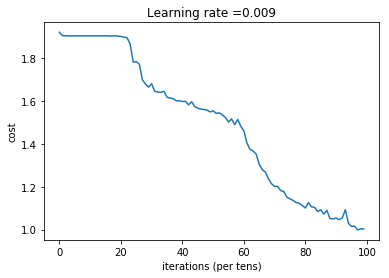

Tensor("Mean_1:0", shape=(), dtype=float32)
Train Accuracy: 0.6657407
Test Accuracy: 0.55833334


In [23]:
_, _, parameters = model(X_train, Y_train, X_test, Y_test)

/home/tree/Downloads/yes/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  
/home/tree/Downloads/yes/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


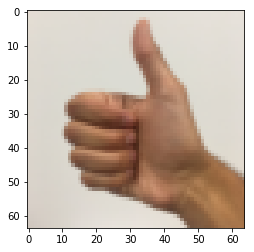

In [26]:
fname = "images/thumbs_up.jpg"
image = np.array(ndimage.imread(fname, flatten=False))
my_image = scipy.misc.imresize(image, size=(64,64))
plt.imshow(my_image)